In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ugk_diyu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ugk_diyu
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import entropy

In [ ]:
inception_model = InceptionV3(include_top=True, weights='imagenet')

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
import tensorflow as tf

# Define the checkpoint path
checkpoint_path = "/content/drive/MyDrive/newcheckpoints"

# Create a checkpoint object
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

# Create a checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=20)

# If a checkpoint exists, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'Latest checkpoint restored: {ckpt_manager.latest_checkpoint}')
else:
    print('No checkpoint found to restore.')


Latest checkpoint restored: /content/drive/MyDrive/newcheckpoints/ckpt-116


Image array:
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]


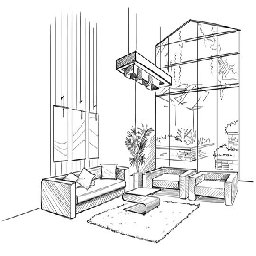

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path, img_size=(256, 256)):
    img = load_img(image_path, target_size=img_size)
    img = img_to_array(img)  # Convert to array
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

input_image_path = '/content/360_F_272841594_9Mij0Ctt51yebXOFsIhbL0LRzRPVoQqn.jpg'
input_image = load_and_preprocess_image(input_image_path)

# Print the image array
print("Image array:")
print(input_image)

# Remove the batch dimension for visualization
image_to_show = np.squeeze(input_image, axis=0)

# Convert the image to the range [0, 255] for visualization
image_to_show = ((image_to_show + 1) * 127.5).astype(np.uint8)

# Display the image
cv2_imshow(image_to_show)


GAN's inception score


In [ ]:
from scipy.stats import entropy
image_folder = '/content/drive/MyDrive/testganffn/'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Generate images using the CycleGAN model
generated_images = []
for image_path in image_paths:  # Iterate over all images in the folder
    input_image = load_and_preprocess_image(image_path)
    fake_y = generator_g(input_image, training=False)
    output_image = (fake_y.numpy()[0] * 127.5 + 127.5).astype(np.uint8)
    generated_images.append(output_image)

generated_images = np.array(generated_images)

# Preprocess the generated images
preprocessed_images = preprocess_images(generated_images)

# Get predictions from the InceptionV3 model
predictions = inception_model.predict(preprocessed_images)

# Function to calculate Inception Score
def calculate_inception_score(predictions, splits=10):
    scores = []
    n = len(predictions)
    split_size = n // splits

    for i in range(splits):
        part = predictions[i * split_size: (i + 1) * split_size, :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(part[j], py) for j in range(split_size)])))

    return np.mean(scores), np.std(scores)

# Calculate and print the Inception Score
mean_is, std_is = calculate_inception_score(predictions)
print(f'Inception Score: {mean_is} ± {std_is}')

51/51 [==============================] - 16s 203ms/step
Inception Score: 3.4401798248291016 ± 0.3222131133079529


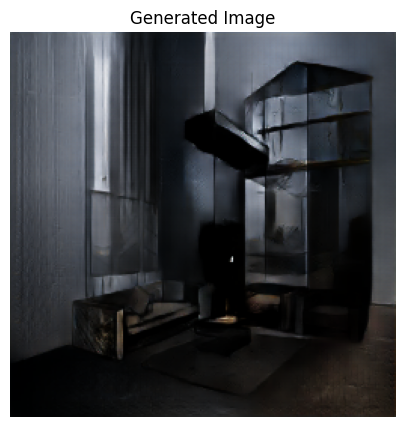

In [ ]:
# Generate the image
fake_y = generator_g(input_image, training=False)  # Set training to False to run in inference mode

# Postprocess to display the image
output_image = (fake_y.numpy()[0] * 127.5 + 127.5).astype(np.uint8)  # Convert back to [0, 255]

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(output_image)
plt.title('Generated Image')
plt.axis('off')
plt.show()


IoU Score: 0.0502


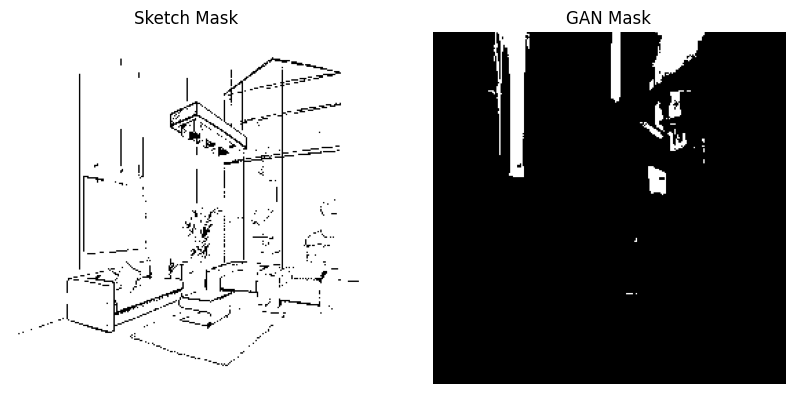

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image_as_gray(image_path, size=(256, 256)):
    """ Load an image file as grayscale and resize it. """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img = cv2.resize(img, size)  # Resize the image to ensure the same dimensions
    return img

def image_to_binary_mask(image, threshold=127):
    """ Convert an image to a binary mask based on a threshold. """
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image / 255  # Convert to 0 and 1

def calculate_iou(mask1, mask2):
    """ Calculate the Intersection over Union (IoU) of two binary masks. """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if np.sum(union) == 0:
        return 0
    else:
        return np.sum(intersection) / np.sum(union)

# Assuming `output_image` is the GAN-generated image already in memory as a NumPy array
if len(output_image.shape) == 3 and output_image.shape[2] == 3:
    gan_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2GRAY)
gan_image = cv2.resize(gan_image, (256, 256))  # Resize GAN image

# Load the sketch image from disk, convert to grayscale if it's in color, and resize it
sketch_path = '/content/360_F_272841594_9Mij0Ctt51yebXOFsIhbL0LRzRPVoQqn.jpg'
sketch_image = load_image_as_gray(sketch_path, size=(256, 256))

# Convert images to binary masks
sketch_mask = image_to_binary_mask(sketch_image, threshold=128)  # Adjust the threshold as necessary
gan_mask = image_to_binary_mask(gan_image, threshold=128)  # Adjust the threshold as necessary

# Calculate IoU
iou_score = calculate_iou(sketch_mask, gan_mask)
print(f"IoU Score: {iou_score:.4f}")

# Visualize the masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sketch_mask, cmap='gray')
plt.title('Sketch Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gan_mask, cmap='gray')
plt.title('GAN Mask')
plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the folder containing input images
input_folder = '/content/drive/MyDrive/testGANffnsketch'

# Initialize a list to store IoU scores
iou_scores = []

# Initialize a counter for the number of images processed
num_images_processed = 0

# Define the maximum number of images to display per figure
max_images_per_figure = 1620

# Create a subplot grid for displaying images
num_images = len(os.listdir(input_folder))
num_cols = 2
num_rows_per_figure = min(num_images, max_images_per_figure) // num_cols
num_figures = (num_images + max_images_per_figure - 1) // max_images_per_figure

for figure_index in range(num_figures):
    start_index = figure_index * max_images_per_figure
    end_index = min((figure_index + 1) * max_images_per_figure, num_images)

    plt.figure(figsize=(10, 5 * num_rows_per_figure))

    # Iterate through each image in the folder
    for idx, filename in enumerate(os.listdir(input_folder)[start_index:end_index], 1):
        # Construct the full path of the input image
        input_image_path = os.path.join(input_folder, filename)

        # Load and preprocess the input image
        input_image = load_and_preprocess_image(input_image_path)

        # Generate the corresponding image using the generator
        fake_y = generator_g(input_image, training=False)
        generated_image = (fake_y.numpy()[0] * 127.5 + 127.5).astype(np.uint8)

        # Calculate the IoU between the generated image and the input sketch
        gan_image = cv2.cvtColor(generated_image, cv2.COLOR_RGB2GRAY)
        gan_image = cv2.resize(gan_image, (256, 256))
        sketch_image = load_image_as_gray(input_image_path, size=(256, 256))
        sketch_mask = image_to_binary_mask(sketch_image, threshold=128)
        gan_mask = image_to_binary_mask(gan_image, threshold=128)
        iou_score = calculate_iou(sketch_mask, gan_mask)

        # Append the IoU score to the list
        print(iou_score)
        iou_scores.append(iou_score)
        num_images_processed += 1

        # Visualize the input sketch and the generated image
    #    plt.subplot(num_rows_per_figure, num_cols, idx)
   #     plt.imshow(sketch_image, cmap='gray')
  #      plt.title('Input Sketch')
 #       plt.axis('off')

      #  plt.subplot(num_rows_per_figure, num_cols, idx + num_cols)
     #   plt.imshow(gan_image, cmap='gray')
    #    plt.title(f'Generated Image\nIoU Score: {iou_score:.4f}')
   #     plt.axis('off')

    # Calculate the average IoU from 0 to the current end index
    overall_average_iou = np.mean(iou_scores)
    print(f"Average IoU from start to image {end_index}: {overall_average_iou:.4f}")

    #plt.tight_layout()
    #plt.show()

# Print the total number of images processed
print(f"Total number of images processed: {num_images_processed}")

# Calculate and print the average IoU for all images
total_average_iou = np.mean(iou_scores)
print(f"Average IoU for all images: {total_average_iou:.4f}")


0.35218968948046087
0.7882699347445488
0.11376447159685422
0.7335371025300453
0.3809786130913804
0.18422069521681422
0.0
0.0
0.13805828761594097
0.057578853696318516
0.00014821646190836928
0.4570592538405267
0.0
0.42180102632014566
0.39890118768683847
0.21904885192317028
0.010265895169090322
0.1668179942220388
0.31028244536075755
0.6436972889133034
0.48722720909165773
0.012757674953552154
0.002884679517107984
0.5350429864992972
0.8374868153838888
0.017914961458179248
0.12077892474518871
9.92358836955443e-05
0.5470523558516315
0.035980350694557406
0.17518675111549323
0.5926709288724382
0.7499644656422243
0.8182269083694661
0.5907953396642305
0.14387675901866162
0.1440534638183281
0.006390890076690681
0.706246889399072
0.49848389134554644
0.3722466243696112
0.0
0.4660374893867154
0.6651138048874847
0.08250063618627534
0.2897086235651918
0.4148296593186373
0.08500171045986936
0.13202929915099051
0.10480885718131647
0.407270777131342
0.0010887954572103384
0.9468412347549194
0.0791398136708

ValueError: Image size of 1000x405000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x405000 with 0 Axes>

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
def feature_fusion_network(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    output = Conv2D(3, (1, 1), padding='same', activation='sigmoid')(conv3)
    model = Model(inputs=input_layer, outputs=output)
    return model

def load_model_with_weights(model_path, input_shape):
    model = feature_fusion_network(input_shape)
    model.load_weights(model_path)
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust based on your model training
weights_path = '/content/drive/MyDrive/ffnweights/weights_epoch_01.h5'  # Adjust the filename as needed
ffn_model = load_model_with_weights(weights_path, input_shape)


In [ ]:
def prepare_single_image(image_path, target_size=(256, 256)):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image /= 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension for model prediction
    return image


1/1 [==============================] - 1s 509ms/step


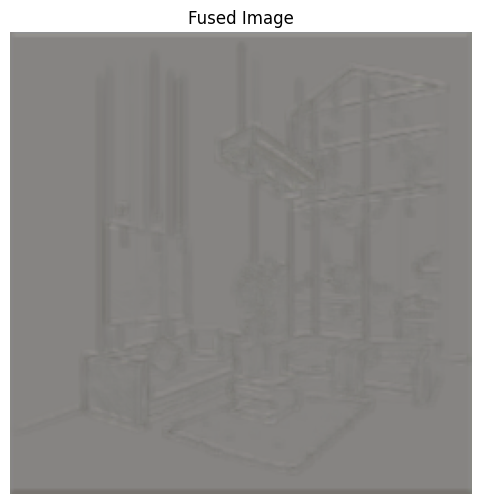

In [ ]:
def generate_fused_images(model, input_images):
    fused_images = model.predict(input_images)
    return fused_images

def prepare_image_from_array(image_array):
    image = image_array / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension for model prediction
    return image

prepared_image = prepare_image_from_array(image_to_show)

# Generate the fused image
fused_image = generate_fused_images(ffn_model, prepared_image)

# Convert the fused image for visualization
fused_image = np.clip(fused_image.squeeze(), 0, 1)  # Remove batch dimension and clip values

# Display the fused image
plt.figure(figsize=(6, 6))
plt.imshow(fused_image)
plt.title('Fused Image')
plt.axis('off')
plt.show()


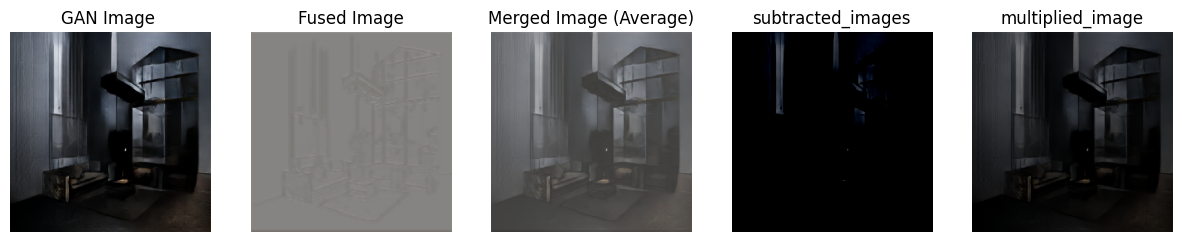

<Figure size 1500x500 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os



def merge_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 + image2) / 2.0
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1


def subtract_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 - image2)
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1

def multiply_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 * image2)%255
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1


def visualize_images(images, titles, figsize=(15, 5)):
    """Display a list of images with titles."""
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()









generator_image = output_image
fused_image = fused_image
generator_image = generator_image / 255.0 if np.max(generator_image) > 1 else generator_image
fused_image = fused_image / 255.0 if np.max(fused_image) > 1 else fused_image

merged_image=merge_images( generator_image, fused_image)
merged_image = np.clip(merged_image.squeeze(), 0, 1)


subtracted_image=subtract_images( generator_image, fused_image)
subtracted_image = np.clip(subtracted_image.squeeze(), 0, 1)

multiplied_image=multiply_images( generator_image, fused_image)
multiplied_image = np.clip(multiplied_image.squeeze(), 0, 1)



visualize_images(
        [generator_image, fused_image, merged_image,subtracted_image,
        multiplied_image],
   ['GAN Image ', 'Fused Image', 'Merged Image (Average)','subtracted_images','multiplied_image']
)
visualize_images(
    [],
    []
)

Number of images: 1620
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 20ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0


KeyboardInterrupt: 

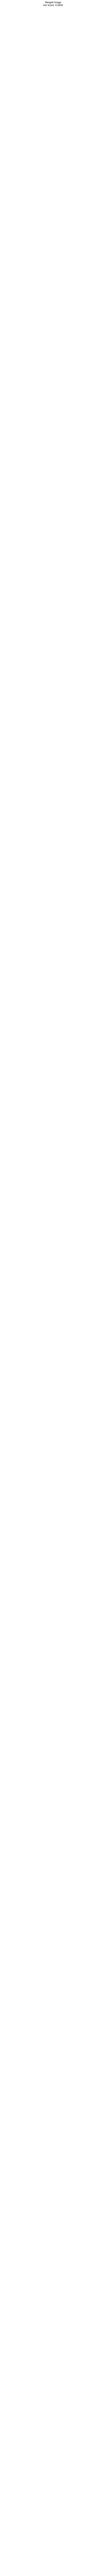

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Ensure these functions are properly defined
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))  # Assuming this is the required input size
    image = (image - 127.5) / 127.5  # Normalize the image
    return image[np.newaxis, ...]  # Adding batch dimension

def merge_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 + image2) / 2.0
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1

def load_image_as_gray(image_path, size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return image

def image_to_binary_mask(image, threshold):
    _, mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return mask

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if np.sum(union) == 0:
        return 0
    else:
        return np.sum(intersection) / np.sum(union)



# Define the folder containing input images
input_folder = '/content/drive/MyDrive/testGANffnsketch'

# Initialize a list to store IoU scores
iou_scores = []

# Initialize a counter for the number of images processed
num_images_processed = 0

# Define the maximum number of images to display per figure
max_images_per_figure = 100

# Create a subplot grid for displaying images
num_images = len(os.listdir(input_folder))
num_cols = 2
num_rows_per_figure = min(num_images, max_images_per_figure) // num_cols
num_figures = (num_images + max_images_per_figure - 1) // max_images_per_figure

print(f"Number of images: {num_images}")

for figure_index in range(num_figures):
    start_index = figure_index * max_images_per_figure
    end_index = min((figure_index + 1) * max_images_per_figure, num_images)

    plt.figure(figsize=(10, 5 * num_rows_per_figure))

    for idx, filename in enumerate(os.listdir(input_folder)[start_index:end_index], 1):
        input_image_path = os.path.join(input_folder, filename)
        input_image = load_and_preprocess_image(input_image_path)

        fake_y = generator_g(input_image, training=False)  # Check generator_g definition
        generated_image = (fake_y.numpy()[0] * 127.5 + 127.5).astype(np.uint8)

        fused_image = generate_fused_images(ffn_model, input_image)  # Check ffn_model is defined and loaded
        merged_image = merge_images(generated_image, fused_image[0])

        merged_gray = cv2.cvtColor(merged_image, cv2.COLOR_RGB2GRAY)
        merged_gray = cv2.resize(merged_gray, (256, 256))
        sketch_image = load_image_as_gray(input_image_path, size=(256, 256))
        sketch_mask = image_to_binary_mask(sketch_image, threshold=128)
        merged_mask = image_to_binary_mask(merged_gray, threshold=128)
        iou_score = calculate_iou(sketch_mask, merged_mask)
        print(iou_score)
        iou_scores.append(iou_score)
        num_images_processed += 1

       # plt.subplot(num_rows_per_figure, num_cols, idx * 2 - 1)
       # plt.imshow(sketch_image, cmap='gray')
        #plt.title('Input Sketch')
       # plt.axis('off')

        #plt.subplot(num_rows_per_figure, num_cols, idx * 2)
        #plt.imshow(merged_image)
        plt.title(f'Merged Image\nIoU Score: {iou_score:.4f}')
        plt.axis('off')

    average_iou = np.mean(iou_scores[start_index:end_index])
    print(f"Average IoU for images {start_index+1}-{end_index}: {average_iou:.4f}")

    plt.tight_layout()
    plt.show()

print(f"Total number of images processed: {num_images_processed}")


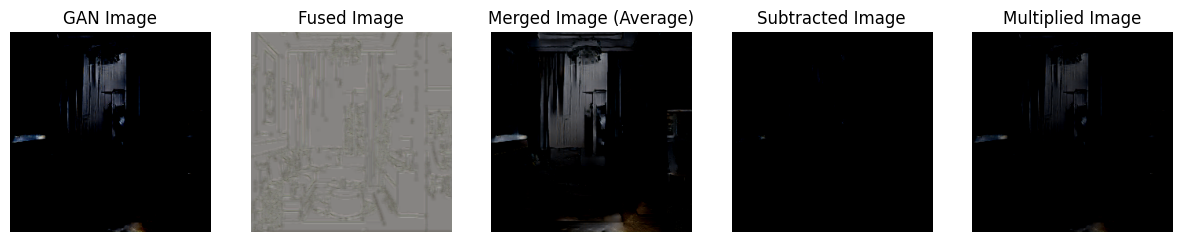

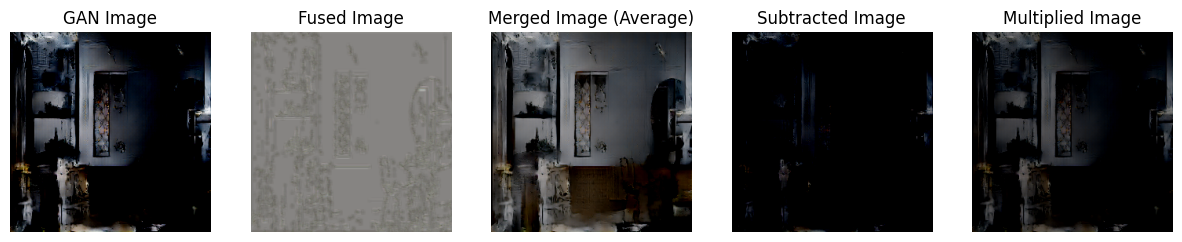

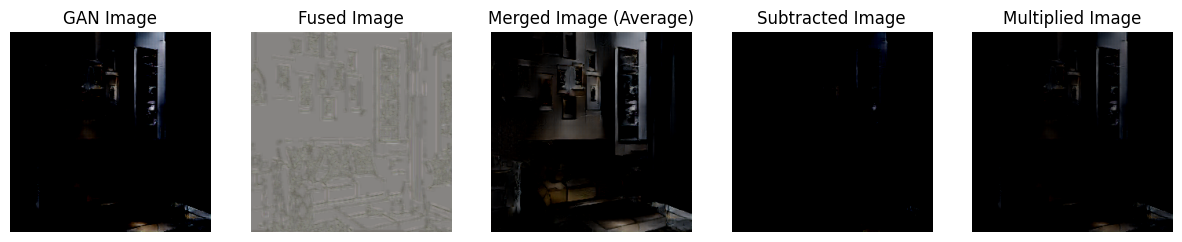

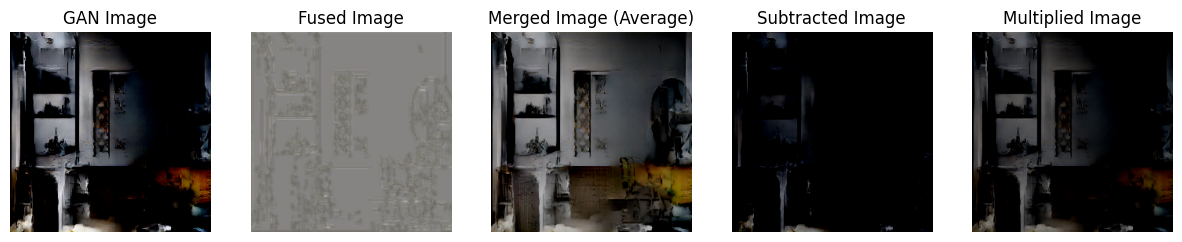

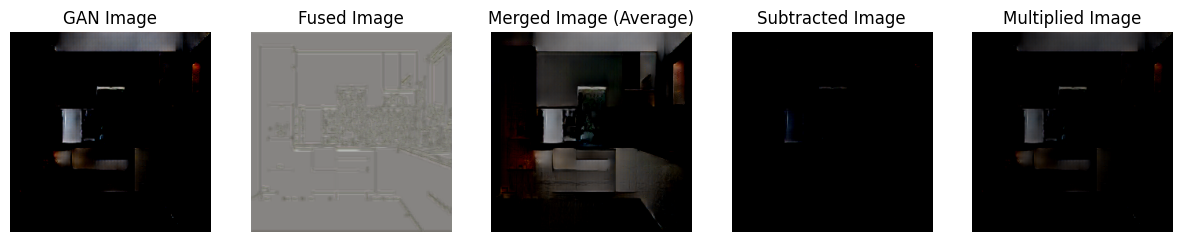

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))  # Assuming this is the required input size
    return (image - 127.5) / 127.5  # Normalize the image to [-1, 1]

def normalize_image(image):
    """Normalize image to [0, 1] scale."""
    return image / 255.0 if np.max(image) > 1 else image

def image_operations(image1, image2):
    """Perform merging, subtracting, and multiplying operations on two images."""
    # Normalize images
    image1 = normalize_image(image1.astype(np.float32))
    image2 = normalize_image(image2.astype(np.float32))

    # Merge by averaging
    merged = np.clip((image1 + image2) / 2.0, 0, 1)

    # Subtract images
    subtracted = np.clip(image1 - image2, 0, 1)

    # Multiply images
    multiplied = np.clip(image1 * image2, 0, 1)

    return merged, subtracted, multiplied

def visualize_images(images, titles, figsize=(15, 5)):
    """Display a list of images with titles."""
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')
    plt.show()

input_folder = '/content/drive/MyDrive/testGANffnsketch'
file_list = os.listdir(input_folder)

for filename in file_list[:5]:  # Limiting to first 5 for demonstration
    input_image_path = os.path.join(input_folder, filename)
    input_image = load_and_preprocess_image(input_image_path)[np.newaxis, ...]

    # Generate images using models
    generator_image = generator_g(input_image, training=False).numpy()[0]
    fused_image = ffn_model(input_image).numpy()[0]

    # Perform operations
    merged_image, subtracted_image, multiplied_image = image_operations(generator_image, fused_image)

    # Visualize results
    visualize_images(
        [generator_image, fused_image, merged_image, subtracted_image, multiplied_image],
        ['GAN Image', 'Fused Image', 'Merged Image (Average)', 'Subtracted Image', 'Multiplied Image']
    )


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))  # Assuming this is the required input size
    return (image - 127.5) / 127.5  # Normalize the image to [-1, 1]

def normalize_image(image):
    """Normalize image to [0, 1] scale."""
    return image / 255.0 if np.max(image) > 1 else image

def image_operations(image1, image2):
    """Perform merging, subtracting, and multiplying operations on two images."""
    # Normalize images
    image1 = normalize_image(image1.astype(np.float32))
    image2 = normalize_image(image2.astype(np.float32))

    # Merge by averaging
    merged = np.clip((image1 + image2) / 2.0, 0, 1)

    # Subtract images (ensure no negative values)
    subtracted = np.clip(image1 - image2, 0, 1)

    # Multiply images (ensure values are in [0, 1])
    multiplied = np.clip(image1 * image2, 0, 1)

    return merged, subtracted, multiplied

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if np.sum(union) == 0:
        return 0
    else:
        return np.sum(intersection) / np.sum(union)

def create_binary_mask(image, threshold=127):
    """Convert a normalized image to a binary mask, ensuring it is grayscale."""
    # Check if the image has three channels (color image) and convert to grayscale
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        image = (image * 255).astype(np.uint8)

    # Threshold image to convert to binary
    _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask

input_folder = '/content/drive/MyDrive/testGANffnsketch'
file_list = os.listdir(input_folder)

ious_merged = []
ious_subtracted = []
ious_multiplied = []

for filename in file_list:  # Process all files in the folder
    input_image_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (256, 256))
    original_mask = create_binary_mask(original_image / 255.0)

    input_image = load_and_preprocess_image(input_image_path)[np.newaxis, ...]

    # Generate images using models
    generator_image = generator_g(input_image, training=False).numpy()[0]
    fused_image = ffn_model(input_image).numpy()[0]

    # Normalize and ensure grayscale if necessary
    generator_image = normalize_image(generator_image)
    fused_image = normalize_image(fused_image)

    # Ensure images are grayscale for mask creation
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY) if input_image.ndim == 3 else input_image
    generator_image_gray = cv2.cvtColor(generator_image, cv2.COLOR_RGB2GRAY) if generator_image.ndim == 3 else generator_image

    # Perform operations
    merged_image, subtracted_image, multiplied_image = image_operations(generator_image, fused_image)

    fused_image_gray = cv2.cvtColor(fused_image, cv2.COLOR_RGB2GRAY) if fused_image.ndim == 3 else fused_image

    # Create binary masks from operations
    input_mask = create_binary_mask(input_image_gray)
    merged_mask = create_binary_mask(merged_image)
    subtracted_mask = create_binary_mask(subtracted_image, threshold=50)  # Lower threshold
    multiplied_mask = create_binary_mask(multiplied_image, threshold=50)  # Lower threshold

    # Calculate IoU for each operation
    iou_merged = calculate_iou(original_mask, merged_mask)
    iou_subtracted = calculate_iou(original_mask, subtracted_mask)
    iou_multiplied = calculate_iou(original_mask, multiplied_mask)

    ious_merged.append(iou_merged)
    print('iou merged: ', iou_merged)
    ious_subtracted.append(iou_subtracted)
    print('iou subtracted: ', iou_subtracted)
    ious_multiplied.append(iou_multiplied)
    print('iou multiplied: ', iou_multiplied)

# Calculate and print average IoUs
average_iou_merged = np.mean(ious_merged)
average_iou_subtracted = np.mean(ious_subtracted)
average_iou_multiplied = np.mean(ious_multiplied)

print(f"Average IoU for Merged Images: {average_iou_merged:.4f}")
print(f"Average IoU for Subtracted Images: {average_iou_subtracted:.4f}")
print(f"Average IoU for Multiplied Images: {average_iou_multiplied:.4f}")


iou merged:  0.0012906686333998224
iou subtracted:  0.00011733351212725657
iou multiplied:  0.004877721718433095
iou merged:  0.06149723988765859
iou subtracted:  0.006343620867768595
iou multiplied:  0.11390300976357622
iou merged:  0.011679324894514767
iou subtracted:  0.00037130801687763714
iou multiplied:  0.02180590717299578
iou merged:  0.10742960533755513
iou subtracted:  0.01594610314075223
iou multiplied:  0.16585365853658537
iou merged:  0.012230578069420307
iou subtracted:  0.00030861189617646103
iou multiplied:  0.04564133383143567
iou merged:  0.008828425849630887
iou subtracted:  0.002001109859249668
iou multiplied:  0.015420317150688617
iou merged:  0.0
iou subtracted:  0.0
iou multiplied:  0.0
iou merged:  0.0
iou subtracted:  0.0
iou multiplied:  0.0
iou merged:  0.0
iou subtracted:  0.0
iou multiplied:  6.592827004219409e-05
iou merged:  0.0004118412599047823
iou subtracted:  9.884190237714775e-05
iou multiplied:  0.0007248406174324169
iou merged:  0.0
iou subtracted:

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=True, weights='imagenet')

# Define the folder containing input images
input_folder = '/content/drive/MyDrive/testGANffnsketch'
file_list = os.listdir(input_folder)

merged_images = []
subtracted_images = []
multiplied_images = []

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    return (image - 127.5) / 127.5  # Normalize to [-1, 1]

def normalize_image(image):
    return image / 255.0 if np.max(image) > 1 else image

def image_operations(image1, image2):
    image1 = normalize_image(image1.astype(np.float32))
    image2 = normalize_image(image2.astype(np.float32))

    merged = np.clip((image1 + image2) / 2.0, 0, 1)
    subtracted = np.clip(image1 - image2, 0, 1)
    multiplied = np.clip(image1 * image2, 0, 1)

    return merged, subtracted, multiplied

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    # Convert grayscale to RGB by repeating the single channel 3 times
    if images_resized.shape[-1] == 1:
        images_resized = tf.image.grayscale_to_rgb(images_resized)
    return preprocess_input(images_resized)

def calculate_inception_score(predictions, splits=10):
    scores = []
    n = len(predictions)
    split_size = n // splits

    for i in range(splits):
        part = predictions[i * split_size: (i + 1) * split_size, :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(part[j], py) for j in range(split_size)])))

    return np.mean(scores), np.std(scores)

# Process all files in the folder
for filename in file_list:
    input_image_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (256, 256))

    input_image = load_and_preprocess_image(input_image_path)[np.newaxis, ...]

    # Generate images using models
    generator_image = generator_g(input_image, training=False).numpy()[0]
    fused_image = ffn_model(input_image).numpy()[0]

    # Normalize and ensure grayscale if necessary
    generator_image = normalize_image(generator_image)
    fused_image = normalize_image(fused_image)

    # Perform operations
    merged_image, subtracted_image, multiplied_image = image_operations(generator_image, fused_image)

    # Convert to RGB by repeating the single channel 3 times if necessary
    merged_image_rgb = np.stack([merged_image] * 3, axis=-1) if merged_image.ndim == 2 else merged_image
    subtracted_image_rgb = np.stack([subtracted_image] * 3, axis=-1) if subtracted_image.ndim == 2 else subtracted_image
    multiplied_image_rgb = np.stack([multiplied_image] * 3, axis=-1) if multiplied_image.ndim == 2 else multiplied_image

    # Collect images
    merged_images.append(merged_image_rgb)
    subtracted_images.append(subtracted_image_rgb)
    multiplied_images.append(multiplied_image_rgb)

# Convert lists to numpy arrays and ensure they have 4 dimensions
merged_images = np.array(merged_images)
subtracted_images = np.array(subtracted_images)
multiplied_images = np.array(multiplied_images)

# Preprocess images for InceptionV3 model
preprocessed_merged_images = preprocess_images(merged_images)
preprocessed_subtracted_images = preprocess_images(subtracted_images)
preprocessed_multiplied_images = preprocess_images(multiplied_images)

# Get predictions from the InceptionV3 model
predictions_merged = inception_model.predict(preprocessed_merged_images)
predictions_subtracted = inception_model.predict(preprocessed_subtracted_images)
predictions_multiplied = inception_model.predict(preprocessed_multiplied_images)

# Calculate Inception Score for each set of images
mean_is_merged, std_is_merged = calculate_inception_score(predictions_merged)
mean_is_subtracted, std_is_subtracted = calculate_inception_score(predictions_subtracted)
mean_is_multiplied, std_is_multiplied = calculate_inception_score(predictions_multiplied)

# Print Inception Scores
print(f'Inception Score for Merged Images: {mean_is_merged:.4f} ± {std_is_merged:.4f}')
print(f'Inception Score for Subtracted Images: {mean_is_subtracted:.4f} ± {std_is_subtracted:.4f}')
print(f'Inception Score for Multiplied Images: {mean_is_multiplied:.4f} ± {std_is_multiplied:.4f}')


51/51 [==============================] - 6s 116ms/step
Inception Score for Merged Images: 1.0040 ± 0.0004
Inception Score for Subtracted Images: 1.0010 ± 0.0002
Inception Score for Multiplied Images: 1.0019 ± 0.0002


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy
from sklearn.metrics import precision_score, recall_score

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=True, weights='imagenet')

# Define the folder containing input images
input_folder = '/content/drive/MyDrive/testGANffnsketch'
file_list = os.listdir(input_folder)

merged_images = []
subtracted_images = []
multiplied_images = []
gan_images = []

# For precision and recall
ground_truth_images = []

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    return (image - 127.5) / 127.5  # Normalize to [-1, 1]

def normalize_image(image):
    return image / 255.0 if np.max(image) > 1 else image



def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    # Convert grayscale to RGB by repeating the single channel 3 times
    if images_resized.shape[-1] == 1:
        images_resized = tf.image.grayscale_to_rgb(images_resized)
    return preprocess_input(images_resized)

def calculate_inception_score(predictions, splits=10):
    scores = []
    n = len(predictions)
    split_size = n // splits

    for i in range(splits):
        part = predictions[i * split_size: (i + 1) * split_size, :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(part[j], py) for j in range(split_size)])))

    return np.mean(scores), np.std(scores)

def create_binary_mask(image):
    """Convert a normalized image to a binary mask, ensuring it is grayscale."""
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        image = (image * 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_mask

def calculate_precision_recall(y_true, y_pred):
    true_positive = np.sum(np.logical_and(y_true == 255, y_pred == 255))
    false_positive = np.sum(np.logical_and(y_true == 0, y_pred == 255))
    false_negative = np.sum(np.logical_and(y_true == 255, y_pred == 0))

    precision = true_positive / (true_positive + false_positive + 1e-9)
    recall = true_positive / (true_positive + false_negative + 1e-9)

    return precision, recall



# Process all files in the folder
for filename in file_list:
    input_image_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (256, 256))

    input_image = load_and_preprocess_image(input_image_path)[np.newaxis, ...]

    # Generate images using models
    generator_image = generator_g(input_image, training=False).numpy()[0]
    fused_image = ffn_model(input_image).numpy()[0]

    # Normalize and ensure grayscale if necessary
    generator_image = normalize_image(generator_image)
    fused_image = normalize_image(fused_image)



    # Perform operations
    merged_image, subtracted_image, multiplied_image = image_operations(generator_image, fused_image)

    generator_image_gray = cv2.cvtColor(generator_image, cv2.COLOR_RGB2GRAY) if generator_image.ndim == 3 else generator_image
    fused_image_gray = cv2.cvtColor(fused_image, cv2.COLOR_RGB2GRAY) if fused_image.ndim == 3 else fused_image
    # Convert to RGB by repeating the single channel 3 times
    merged_image_rgb = np.stack([merged_image] * 3, axis=-1)
    subtracted_image_rgb = np.stack([subtracted_image] * 3, axis=-1)
    multiplied_image_rgb = np.stack([multiplied_image] * 3, axis=-1)
    generator_image_rgb = np.stack([generator_image_gray] * 3, axis=-1)

    # Collect images
    merged_images.append(merged_image_rgb)
    subtracted_images.append(subtracted_image_rgb)
    multiplied_images.append(multiplied_image_rgb)
    gan_images.append(generator_image_rgb)

    # Collect ground truth images for precision and recall
    ground_truth_images.append(original_image)

# Convert lists to numpy arrays
merged_images = np.array(merged_images)
subtracted_images = np.array(subtracted_images)
multiplied_images = np.array(multiplied_images)
gan_images = np.array(gan_images)



# Get predictions from the InceptionV3 model


# Calculate precision and recall for each set of images
ground_truth_masks = np.array([create_binary_mask(img) for img in ground_truth_images])
gan_masks = np.array([create_binary_mask(img) for img in gan_images])
merged_masks = np.array([create_binary_mask(img) for img in merged_images])
subtracted_masks = np.array([create_binary_mask(img) for img in subtracted_images])
multiplied_masks = np.array([create_binary_mask(img) for img in multiplied_images])

precision_gan, recall_gan = calculate_precision_recall(ground_truth_masks, gan_masks)
precision_merged, recall_merged = calculate_precision_recall(ground_truth_masks, merged_masks)
precision_subtracted, recall_subtracted = calculate_precision_recall(ground_truth_masks, subtracted_masks)
precision_multiplied, recall_multiplied = calculate_precision_recall(ground_truth_masks, multiplied_masks)

# Print Inception Scores, Precision, and Recall

print(f'Precision for GAN Images: {precision_gan:.4f}')
print(f'Recall for GAN Images: {recall_gan:.4f}')
print(f'Precision for Merged Images: {precision_merged:.4f}')
print(f'Recall for Merged Images: {recall_merged:.4f}')
print(f'Precision for Subtracted Images: {precision_subtracted:.4f}')
print(f'Recall for Subtracted Images: {recall_subtracted:.4f}')
print(f'Precision for Multiplied Images: {precision_multiplied:.4f}')
print(f'Recall for Multiplied Images: {recall_multiplied:.4f}')


Precision for GAN Images: 0.0265
Recall for GAN Images: 0.0926
Precision for Merged Images: 0.0559
Recall for Merged Images: 0.0325
Precision for Subtracted Images: 0.0649
Recall for Subtracted Images: 0.0000
Precision for Multiplied Images: 0.0635
Recall for Multiplied Images: 0.0004


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Define the folders containing input and ground truth images
input_folder = '/content/drive/MyDrive/testGANffnsketch'
groundtruth_folder = '/content/drive/MyDrive/testganffn'

# List all files in the input and ground truth folders
input_files = {os.path.splitext(file)[0]: file for file in os.listdir(input_folder) if file.endswith(('.png', '.jpg'))}
ground_truth_files = {os.path.splitext(file)[0]: file for file in os.listdir(groundtruth_folder) if file.endswith(('.png', '.jpg'))}

print("Input Files:", input_files)  # Debugging output
print("Ground Truth Files:", ground_truth_files)  # Debugging output

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Normalize image
def normalize_image(img):
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    if np.any(np.isnan(normalized_img)) or np.any(np.isinf(normalized_img)):
        print("NaNs or Infs detected after normalization.")
    return normalized_img

# Preprocess images for InceptionV3 model
def preprocess_images(images):
    preprocessed_images = preprocess_input(images * 255)
    if np.any(np.isnan(preprocessed_images)) or np.any(np.isinf(preprocessed_images)):
        print("NaNs or Infs detected after preprocessing.")
    return preprocessed_images

# Calculate FID score
def calculate_fid(act1, act2, epsilon=1e-3):
    # calculate mean and covariance statistics
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # add epsilon to the diagonal of the covariance matrices
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon

    # print the means and covariance matrices
    print(f"Mean1: {mu1}, Mean2: {mu2}")
    print(f"Covariance Matrix1: {sigma1}")
    print(f"Covariance Matrix2: {sigma2}")
    print(f"Determinant Covariance Matrix1: {np.linalg.det(sigma1)}")
    print(f"Determinant Covariance Matrix2: {np.linalg.det(sigma2)}")

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load InceptionV3 model for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Assuming generator_g is your trained generator model
# generator_g = ...

# Lists to store images for FID calculation
gan_images = []
ground_truth_images = []

# Process each input file and find matching ground truth image
for base_name, input_filename in input_files.items():
    if base_name in ground_truth_files:
        input_image_path = os.path.join(input_folder, input_filename)
        ground_truth_image_path = os.path.join(groundtruth_folder, ground_truth_files[base_name])

        print(f"Processing {input_filename} and {ground_truth_files[base_name]}")  # Debugging output

        # Load and preprocess input image
        input_image = load_and_preprocess_image(input_image_path)
        if input_image is None:
            print(f"Failed to load input image: {input_image_path}")  # Debugging output
            continue  # Skip if input image not found
        input_image = input_image[np.newaxis, ...]

        # Load ground truth image
        ground_truth_image = load_and_preprocess_image(ground_truth_image_path)
        if ground_truth_image is None:
            print(f"Failed to load ground truth image: {ground_truth_image_path}")  # Debugging output
            continue  # Skip if ground truth image not found

        # Verify input image size
        if input_image.shape[1:3] != (256, 256):
            print(f"Input image {input_image_path} has incorrect size {input_image.shape[1:3]}. Expected (256, 256).")
            continue

        # Generate image using the generator model (assuming generator_g is defined)
        generator_image = generator_g(input_image, training=False).numpy()[0]
        generator_image = normalize_image(generator_image)

        # Resize generated and ground truth images to 299x299 for InceptionV3
        generator_image_resized = np.array(Image.fromarray((generator_image * 255).astype(np.uint8)).resize((299, 299))) / 255.0
        ground_truth_image_resized = np.array(Image.fromarray((ground_truth_image * 255).astype(np.uint8)).resize((299, 299))) / 255.0

        # Collect images for FID calculation
        gan_images.append(generator_image_resized)
        ground_truth_images.append(ground_truth_image_resized)

# Check if there are any images to process
if not gan_images or not ground_truth_images:
    print("No images to process.")
else:
    # Convert lists to numpy arrays for processing
    gan_images = np.array(gan_images)
    ground_truth_images = np.array(ground_truth_images)

    # Preprocess images for InceptionV3 model
    preprocessed_gan_images = preprocess_images(gan_images)
    preprocessed_ground_truth_images = preprocess_images(ground_truth_images)

    # Verify preprocessed shapes
    print(f"Preprocessed GAN images shape: {preprocessed_gan_images.shape}")
    print(f"Preprocessed ground truth images shape: {preprocessed_ground_truth_images.shape}")

    # Get activations from the InceptionV3 model
    activations_ground_truth = inception_model.predict(preprocessed_ground_truth_images)
    activations_gan = inception_model.predict(preprocessed_gan_images)

    # Verify activations shapes and summary statistics
    print(f"Activations ground truth shape: {activations_ground_truth.shape}")
    print(f"Activations GAN shape: {activations_gan.shape}")
    print(f"Activations ground truth mean: {np.mean(activations_ground_truth)}, std: {np.std(activations_ground_truth)}")
    print(f"Activations GAN mean: {np.mean(activations_gan)}, std: {np.std(activations_gan)}")

    # Ensure there are no NaNs or Infs in activations
    if np.any(np.isnan(activations_ground_truth)) or np.any(np.isnan(activations_gan)):
        print("NaNs detected in activations.")
    elif np.any(np.isinf(activations_ground_truth)) or np.any(np.isinf(activations_gan)):
        print("Infs detected in activations.")
    else:
        # Calculate FID score
        fid_gan = calculate_fid(activations_ground_truth, activations_gan)

        # Check for NaNs or Infs in FID score
        if np.isnan(fid_gan) or np.isinf(fid_gan):
            print("FID score calculation resulted in NaN or Inf values. Check the input images and activations for errors.")
        else:
            # Print FID Scores
            print(f'FID Score for GAN Images: {fid_gan:.4f}')


Input Files: {'1283': '1283.jpg', '1284': '1284.jpg', '1285': '1285.jpg', '1286': '1286.jpg', '1287': '1287.jpg', '1288': '1288.jpg', '1289': '1289.jpg', '1290': '1290.jpg', '1291': '1291.jpg', '1292': '1292.jpg', '1293': '1293.jpg', '1294': '1294.jpg', '1295': '1295.jpg', '1296': '1296.jpg', '1297': '1297.jpg', '1298': '1298.jpg', '1299': '1299.jpg', '1300': '1300.jpg', '1301': '1301.jpg', '1302': '1302.jpg', '1303': '1303.jpg', '1304': '1304.jpg', '1305': '1305.jpg', '1306': '1306.jpg', '1307': '1307.jpg', '1308': '1308.jpg', '1309': '1309.jpg', '1310': '1310.jpg', '1311': '1311.jpg', '1312': '1312.jpg', '1313': '1313.jpg', '1314': '1314.jpg', '1315': '1315.jpg', '1316': '1316.jpg', '1317': '1317.jpg', '1318': '1318.jpg', '1319': '1319.jpg', '1320': '1320.jpg', '1321': '1321.jpg', '1322': '1322.jpg', '1324': '1324.jpg', '1325': '1325.jpg', '1327': '1327.jpg', '1328': '1328.jpg', '1329': '1329.jpg', '1330': '1330.jpg', '1331': '1331.jpg', '1332': '1332.jpg', '1333': '1333.jpg', '1334'

In [ ]:
import os

# Define the folders containing the images
folder1 = '/content/drive/MyDrive/testGANffnsketch'
folder2 = '/content/drive/MyDrive/testganffn'

# Get the list of filenames in each folder
files1 = os.listdir(folder1)
files2 = os.listdir(folder2)

# Extract the common filenames without file extensions
common_filenames = set([os.path.splitext(file)[0] for file in files1]).intersection([os.path.splitext(file)[0] for file in files2])

# Iterate over the common filenames and process the matching images
for filename in common_filenames:
    image_path1 = os.path.join(folder1, filename + '.png')  # Assuming the images have jpg extension
    image_path2 = os.path.join(folder2, filename + '.png')  # Assuming the images have jpg extension

    # Now you have the paths to corresponding images, you can further process them as needed
print(common_filenames)

TypeError: 'set' object is not subscriptable

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf

# Define the folder containing input images
input_folder = '/content/drive/MyDrive/testGANffnsketch'
file_list = os.listdir(input_folder)

merged_images = []
subtracted_images = []
multiplied_images = []
gan_images = []
ground_truth_images = []

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    return (image - 127.5) / 127.5  # Normalize to [-1, 1]

def normalize_image(image):
    return image / 255.0 if np.max(image) > 1 else image

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    # Convert grayscale to RGB by repeating the single channel 3 times
    if images_resized.shape[-1] == 1:
        images_resized = tf.image.grayscale_to_rgb(images_resized)
    return preprocess_input(images_resized)

def create_binary_mask(image):
    """Convert a normalized image to a binary mask, ensuring it is grayscale."""
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        image = (image * 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_mask

def calculate_accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    accuracy = correct_pixels / total_pixels
    return accuracy

# Process all files in the folder
for filename in file_list:
    input_image_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (256, 256))

    input_image = load_and_preprocess_image(input_image_path)[np.newaxis, ...]

    # Generate images using models
    generator_image = generator_g(input_image, training=False).numpy()[0]
    fused_image = ffn_model(input_image).numpy()[0]

    # Normalize and ensure grayscale if necessary
    generator_image = normalize_image(generator_image)
    fused_image = normalize_image(fused_image)

    # Perform operations
    merged_image, subtracted_image, multiplied_image = image_operations(generator_image, fused_image)

    generator_image_gray = cv2.cvtColor(generator_image, cv2.COLOR_RGB2GRAY) if generator_image.ndim == 3 else generator_image
    fused_image_gray = cv2.cvtColor(fused_image, cv2.COLOR_RGB2GRAY) if fused_image.ndim == 3 else fused_image
    # Convert to RGB by repeating the single channel 3 times
    merged_image_rgb = np.stack([merged_image] * 3, axis=-1)
    subtracted_image_rgb = np.stack([subtracted_image] * 3, axis=-1)
    multiplied_image_rgb = np.stack([multiplied_image] * 3, axis=-1)
    generator_image_rgb = np.stack([generator_image_gray] * 3, axis=-1)

    # Collect images
    merged_images.append(merged_image_rgb)
    subtracted_images.append(subtracted_image_rgb)
    multiplied_images.append(multiplied_image_rgb)
    gan_images.append(generator_image_rgb)

    # Collect ground truth images for accuracy calculation
    ground_truth_images.append(np.stack([original_image] * 3, axis=-1))

# Convert lists to numpy arrays
merged_images = np.array(merged_images)
subtracted_images = np.array(subtracted_images)
multiplied_images = np.array(multiplied_images)
gan_images = np.array(gan_images)
ground_truth_images = np.array(ground_truth_images)

# Convert ground truth and generated images to binary masks
ground_truth_masks = np.array([create_binary_mask(img) for img in ground_truth_images])
gan_masks = np.array([create_binary_mask(img) for img in gan_images])
merged_masks = np.array([create_binary_mask(img) for img in merged_images])
subtracted_masks = np.array([create_binary_mask(img) for img in subtracted_images])
multiplied_masks = np.array([create_binary_mask(img) for img in multiplied_images])

# Calculate accuracy for each set of images
accuracy_gan = calculate_accuracy(ground_truth_masks, gan_masks)
accuracy_merged = calculate_accuracy(ground_truth_masks, merged_masks)
accuracy_subtracted = calculate_accuracy(ground_truth_masks, subtracted_masks)
accuracy_multiplied = calculate_accuracy(ground_truth_masks, multiplied_masks)

# Print Accuracy
print(f'Accuracy for GAN Images: {accuracy_gan:.4f}')
print(f'Accuracy for Merged Images: {accuracy_merged:.4f}')
print(f'Accuracy for Subtracted Images: {accuracy_subtracted:.4f}')
print(f'Accuracy for Multiplied Images: {accuracy_multiplied:.4f}')
